<a href="https://colab.research.google.com/github/imaboylol/itmo-advanced-ml-and-dl/blob/main/classification-ensembles/Ensembles_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Exploratory Data Analysis

Считайте набор данных в датафрейм

In [1]:
# < ENTER YOUR CODE HERE >
import pandas as pd
df = pd.read_csv('electricity_train.csv')

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [2]:
# < ENTER YOUR CODE HERE >
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36249 entries, 0 to 36248
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       36249 non-null  float64
 1   day        36249 non-null  int64  
 2   period     36249 non-null  float64
 3   nswprice   36249 non-null  float64
 4   nswdemand  36249 non-null  float64
 5   vicprice   36249 non-null  float64
 6   vicdemand  36249 non-null  float64
 7   transfer   36249 non-null  float64
 8   class      36249 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 2.5 MB


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [12]:
# < ENTER YOUR CODE HERE >
df['class'].value_counts(1)

,proportion
class,
0,0.575464
1,0.424536


Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

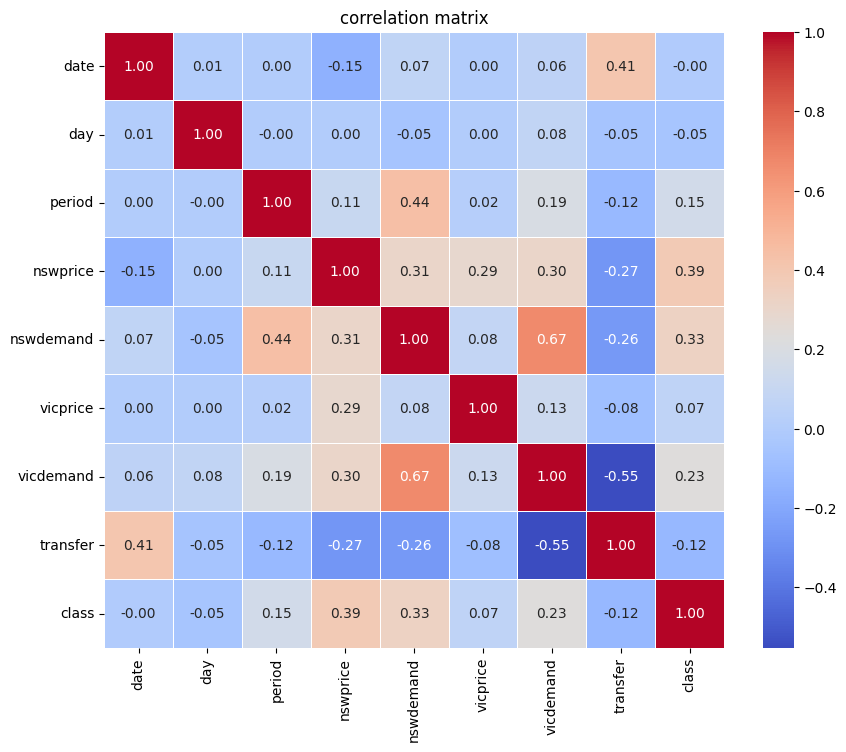

In [18]:
# < ENTER YOUR CODE HERE >
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr()

# Построение тепловой карты корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("correlation matrix")
plt.show()

Постройте гистограммы распределений признаков.

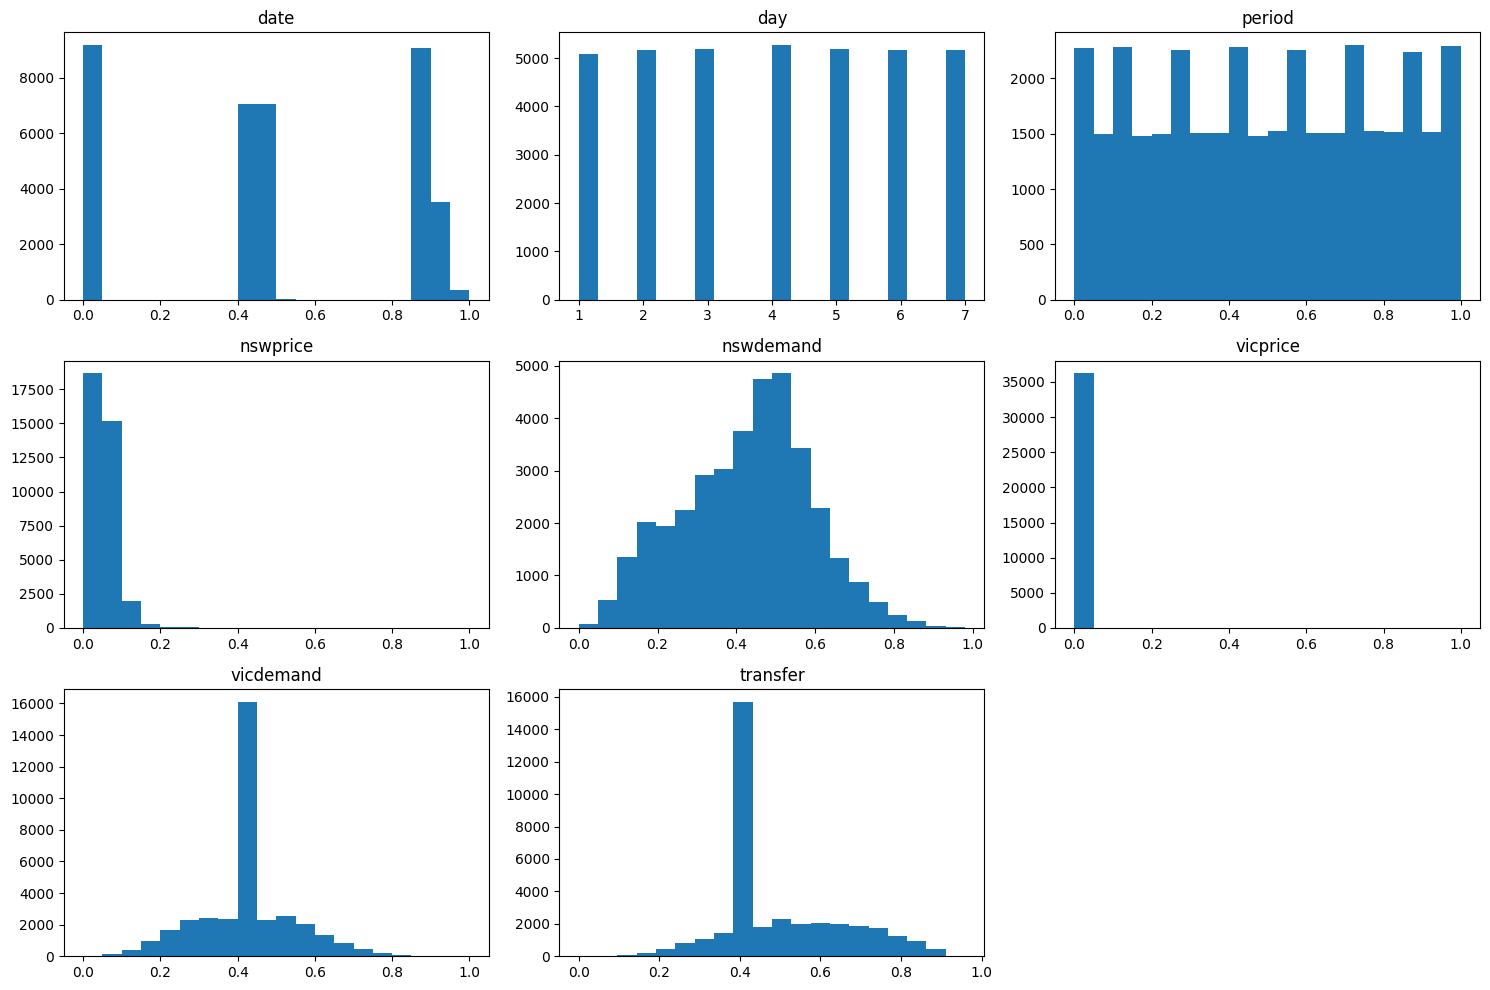

In [20]:
# < ENTER YOUR CODE HERE >
features = df.drop(columns=['class'])

features.hist(bins=20, figsize=(15, 10), grid=False)
plt.tight_layout()
plt.show()

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [21]:
# < ENTER YOUR CODE HERE >
from sklearn.model_selection import train_test_split
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании.

In [28]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import RandomForestClassifier

randforest = RandomForestClassifier(random_state=11)
randforest.fit(X_train, y_train)


y_train_pred = randforest.predict(X_train)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [29]:
# < ENTER YOUR CODE HERE >
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     16668
           1      1.000     1.000     1.000     12331

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании.

Подбираемые параметры:

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [30]:
# < ENTER YOUR CODE HERE >
from sklearn.model_selection import GridSearchCV

params_grid = {
    'n_estimators': [100, 300, 500],
    'max_leaf_nodes': list(range(6, 10)),
    'min_samples_leaf': [1, 2, 3]
}

rf_model = RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=11
)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=params_grid,
    verbose=4,
    cv=3
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   0.8s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.766 total time=   0.8s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.770 total time=   0.8s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.773 total time=   2.4s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.770 total time=   3.4s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.773 total time=   3.5s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.773 total time=   4.0s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.771 total time=   4.4s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.774 total time=   4.4s
[CV 1/3] END max_leaf_nodes=6

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=11),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели.

In [31]:
# < ENTER YOUR CODE HERE >

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Лучшие параметры:", best_params)
print("\nЛучшая модель:\n", best_model)

Лучшие параметры: {'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 100}

Лучшая модель:
 RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_leaf_nodes=9, n_jobs=-1, random_state=11)


Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [33]:
# < ENTER YOUR CODE HERE >
y_train_pred = best_model.predict(X_train)

y_test_pred = best_model.predict(X_test)

train_report = classification_report(y_train, y_train_pred, digits=5)
print("Classification Report (Training Data):\n")
print(train_report)

test_report = classification_report(y_test, y_test_pred, digits=5)
print("\nClassification Report (Test Data):\n")
print(test_report)

Classification Report (Training Data):

              precision    recall  f1-score   support

           0    0.77817   0.87761   0.82490     16668
           1    0.80002   0.66183   0.72439     12331

    accuracy                        0.78585     28999
   macro avg    0.78909   0.76972   0.77465     28999
weighted avg    0.78746   0.78585   0.78216     28999


Classification Report (Test Data):

              precision    recall  f1-score   support

           0    0.78435   0.87285   0.82624      4192
           1    0.79381   0.67103   0.72727      3058

    accuracy                        0.78772      7250
   macro avg    0.78908   0.77194   0.77676      7250
weighted avg    0.78834   0.78772   0.78450      7250



От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [35]:
# < ENTER YOUR CODE HERE >
import numpy as np

feature_importances = best_model.feature_importances_
most_important_index = np.argmax(feature_importances)

most_important_feature = X_train.columns[most_important_index]

print(f"most important feature: {most_important_feature}")
print(f"importance: {feature_importances[most_important_index]:.5f}")

most important feature: nswprice
importance: 0.52199


Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [36]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# базовые классификаторы
logreg = LogisticRegression(solver='liblinear', random_state=11)
svc = SVC(random_state=11, probability=True)
sgd = SGDClassifier(random_state=11)

# VotingClassifier с параметром voting='hard'
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('svc', svc),
        ('sgd', sgd)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

y_test_pred = voting_clf.predict(X_test)

Вычислите точность модели на **тестовых данных**

In [37]:
# < ENTER YOUR CODE HERE >
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Точность модели на тестовых данных: {accuracy:.5f}")

report = classification_report(y_test, y_test_pred, digits=5)
print("\nClassification Report (Test Data):\n")
print(report)

Точность модели на тестовых данных: 0.75986

Classification Report (Test Data):

              precision    recall  f1-score   support

           0    0.75097   0.87476   0.80815      4192
           1    0.77820   0.60235   0.67908      3058

    accuracy                        0.75986      7250
   macro avg    0.76459   0.73856   0.74362      7250
weighted avg    0.76246   0.75986   0.75371      7250



# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [41]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Создание BaggingClassifier с базовым DecisionTreeClassifier
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
    random_state=11
)

bagging_clf.fit(X_train, y_train)

y_test_pred = bagging_clf.predict(X_test)

Вычислите точность модели на **тестовых данных**

In [42]:
# < ENTER YOUR CODE HERE >
report = classification_report(y_test, y_test_pred, digits=5)
print("Classification Report (Test Data):\n")
print(report)

Classification Report (Test Data):

              precision    recall  f1-score   support

           0    0.85942   0.91150   0.88470      4192
           1    0.86769   0.79562   0.83009      3058

    accuracy                        0.86262      7250
   macro avg    0.86356   0.85356   0.85739      7250
weighted avg    0.86291   0.86262   0.86166      7250



# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [43]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import GradientBoostingClassifier

gbm_clf = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.8,
    random_state=11,
    max_depth=2
)

gbm_clf.fit(X_train, y_train)

y_test_pred = gbm_clf.predict(X_test)

Вычислите точность модели на **тестовых данных**

In [44]:
# < ENTER YOUR CODE HERE >
report = classification_report(y_test, y_test_pred, digits=5)
print("Classification Report (Test Data):\n")
print(report)

Classification Report (Test Data):

              precision    recall  f1-score   support

           0    0.88384   0.89480   0.88928      4192
           1    0.85329   0.83878   0.84598      3058

    accuracy                        0.87117      7250
   macro avg    0.86856   0.86679   0.86763      7250
weighted avg    0.87095   0.87117   0.87102      7250



# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [46]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=11
)

ada.fit(X_train, y_train)

y_test_pred = ada.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Вычислите точность модели на **тестовых данных**

In [47]:
# < ENTER YOUR CODE HERE >
report = classification_report(y_test, y_test_pred, digits=5)
print("Classification Report (Test Data):\n")
print(report)

Classification Report (Test Data):

              precision    recall  f1-score   support

           0    0.92773   0.90339   0.91540      4192
           1    0.87216   0.90353   0.88757      3058

    accuracy                        0.90345      7250
   macro avg    0.89995   0.90346   0.90148      7250
weighted avg    0.90429   0.90345   0.90366      7250



# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [48]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import StackingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

estimators = [
    ('rf', RandomForestClassifier(random_state=11)),
    ('svc', SVC(random_state=11, probability=True))  # probability=True для совместимости
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=11),
    cv=3
)

stacking_clf.fit(X_train, y_train)

y_test_pred = stacking_clf.predict(X_test)

Вычислите точность модели на **тестовых данных**

In [49]:
# < ENTER YOUR CODE HERE >
report = classification_report(y_test, y_test_pred, digits=5)
print("Classification Report (Test Data):\n")
print(report)

Classification Report (Test Data):

              precision    recall  f1-score   support

           0    0.91445   0.92056   0.91750      4192
           1    0.89010   0.88195   0.88601      3058

    accuracy                        0.90428      7250
   macro avg    0.90228   0.90126   0.90175      7250
weighted avg    0.90418   0.90428   0.90422      7250

